# TP 8 – Surfaces de volatilité et objets de marché

Ce TP illustre les modules `volatility` et `market` de fypy.

Objectifs :
- comprendre la structure `MarketSlice` et `MarketSurface`;
- construire une surface de volatilité implicite à partir de prix ou d’un pricer de modèle;
- manipuler les conversions de strike (log-moneyness, etc.).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fypy.termstructures.DiscountCurve import DiscountCurve_ConstRate
from fypy.termstructures.EquityForward import EquityForward
from fypy.pricing.analytical.black_scholes import black76_price_strikes
from fypy.market.MarketSlice import MarketSlice
from fypy.market.MarketSurface import MarketSurface
from fypy.volatility.implied.ImpliedVolCalculator import ImpliedVolCalculator_Black76
from fypy.volatility.VolSurface import ModelVolSurfaceSlices
from fypy.volatility.StrikeConverter import LogRelativeStrikeConverter

%matplotlib inline

/home/salok1/RepoFinal/FYPY/fypy/termstructures/DiscountCurve.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.interpolate import interp1d


## 1. MarketSlice : un slice de prix d’options

Un objet `MarketSlice` représente toutes les options (calls/puts) pour une maturité donnée \( T \) :
- `strikes` : vecteur de strikes \( K_i \);
- `is_calls` : booléens (call ou put);
- `mid_prices` (et éventuellement `bid_prices`, `ask_prices`);
- `F` : forward \( F(T) \);
- `disc` : facteur d’actualisation \( D(T) \).

On peut ensuite demander à `MarketSlice` de calculer les **volatilités implicites** via
`fill_implied_vols(ImpliedVolCalculator)`.

In [2]:
# Créons une surface Black-Scholes synthétique, puis ses slices de marché
S0 = 100.0
r = 0.01
q = 0.0

disc_curve = DiscountCurve_ConstRate(rate=r)
div_disc = DiscountCurve_ConstRate(rate=q)
fwd_curve = EquityForward(S0=S0, discount=disc_curve, divDiscount=div_disc)

vol_const = 0.2
ttms = [0.25, 0.5, 1.0, 2.0]
strikes = np.linspace(60.0, 140.0, 15)
is_calls = np.ones(len(strikes), dtype=bool)

surface = MarketSurface(forward_curve=fwd_curve, discount_curve=disc_curve)

for T in ttms:
    F = fwd_curve(T)
    disc = disc_curve(T)
    prices = black76_price_strikes(F=F, K=strikes, is_calls=is_calls, vol=vol_const, disc=disc, T=T)
    mkt_slice = MarketSlice(T=T, F=F, disc=disc, strikes=strikes,
                            is_calls=is_calls, mid_prices=prices)
    surface.add_slice(T, mkt_slice)

ivc = ImpliedVolCalculator_Black76(disc_curve=disc_curve, fwd_curve=fwd_curve)
surface.fill_implied_vols(calculator=ivc)

print('Nombre de slices dans la surface :', surface.num_slices)

Nombre de slices dans la surface : 4


Vérifions que les vols implicites reconstruites sont (quasi) constantes et égales à la volatilité 0.2 utilisée.

In [3]:
for T, sl in surface.slices.items():
    print(f'T = {T:4.2f} : vol implicite moyenne = {np.mean(sl.mid_vols):.4f}')

T = 0.25 : vol implicite moyenne = 0.2000
T = 0.50 : vol implicite moyenne = 0.2000
T = 1.00 : vol implicite moyenne = 0.2000
T = 2.00 : vol implicite moyenne = 0.2000


## 2. Construction d'une surface de vol modèle : ModelVolSurfaceSlices

`ModelVolSurfaceSlices` construit une surface de volatilité modèle à partir :
- d'une surface de marché `MarketSurface` (slices de prix + vols implicites);
- d'un convertisseur de strikes (`StrikeConverter`) pour travailler en log-moneyness, delta, etc.

On peut ensuite :
- interroger `vol(K, T)` pour n’importe quel \( K, T \);
- ou `model_vol(x, T)` pour des coordonnées transformées (par ex. \( x = \ln(K/F) \)).

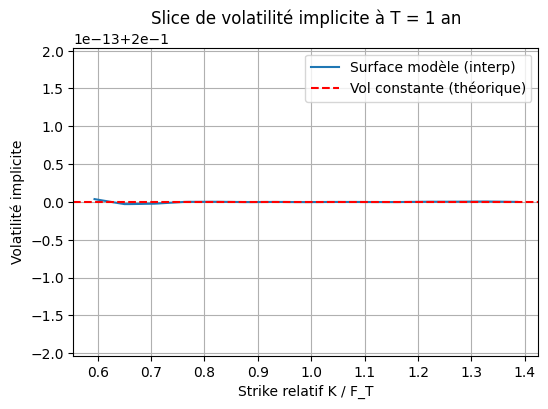

In [4]:
strike_converter = LogRelativeStrikeConverter()
vol_surface_model = ModelVolSurfaceSlices.from_market_surface(surface, strike_converter=strike_converter)

T_plot = 1.0
F_T = fwd_curve(T_plot)
Ks_plot = np.linspace(60.0, 140.0, 100)

vols_interp = vol_surface_model.vol(K=Ks_plot, T=T_plot)

plt.figure(figsize=(6, 4))
plt.plot(Ks_plot / F_T, vols_interp, label='Surface modèle (interp)')
plt.axhline(vol_const, color='red', linestyle='--', label='Vol constante (théorique)')
plt.xlabel('Strike relatif K / F_T')
plt.ylabel('Volatilité implicite')
plt.title('Slice de volatilité implicite à T = 1 an')
plt.grid(True)
plt.legend()
plt.show()

Avec un modèle plus riche (Lévy, Heston, SABR, etc.), la surface ne serait plus plate : on obtiendrait un smile ou
un skew. `ModelVolSurfaceSlices` permet alors :
- d'interpoler entre les maturités connues;
- d'extrapoler au voisinage de la première/dernière maturité.


## 3. Filtres de strikes et de slices

Les modules `MarketSlice` et `MarketSurface` fournissent également des filtres pour nettoyer les données de marché :
- `OTMStrikeFilter`, `StrikeStdDevFilter`, `MidPriceFilter`, etc. pour ne garder que certains strikes;
- `SliceFilter` / `FilterTTM` pour restreindre la surface à certaines maturités.

Ces filtres sont particulièrement utiles avant calibration, pour retirer :
- les options très OTM/ITM (peu liquides, payoff presque nul ou presque linéaire);
- les options avec prix trop bas/erronés.

**Exercice** :
- Construire un `StrikeStdDevFilter` et l’appliquer à un `MarketSlice` pour ne garder que les strikes dans
  un certain nombre d’écarts-types autour du forward;
- Construire une nouvelle `MarketSurface` filtrée et observer l’impact sur la surface de volatilité.